# Structure of the Submission Model


In [ ]:
import tensorflow as tf

class model:
    def __init__(self):
        self.model = tf.keras.models.load_model('saved_model')

    def predict(self, X):

        # Note: this is just an example.
        # Here the model.predict is called, followed by the argmax
        out = self.model.predict(X)
        print(type(out))
        out = (out > 0.5).astype(int)  # Shape [BS]
        print(type(out))
        return tf.convert_to_tensor(np.squeeze(out, axis=-1))

#Downloading the Dataset

In [2]:
import gdown
file_id = '1llWCmIbaW-uHvZcD-soT8DJQJYmm8zAA'
file_path = '/content/dataset.zip'

gdown.download(f'https://drive.google.com/uc?id={file_id}', file_path, quiet=False)
!unzip /content/dataset.zip

Downloading...
From: https://drive.google.com/uc?id=1llWCmIbaW-uHvZcD-soT8DJQJYmm8zAA
To: /content/dataset.zip
100%|██████████| 208M/208M [00:01<00:00, 110MB/s] 


Archive:  /content/dataset.zip
replace public_data.npz? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

#Imports

In [17]:
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.applications import InceptionV3
from keras.models import Model
from keras.optimizers import Adam, AdamW
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Load dataset
data = np.load('/content/public_data.npz', allow_pickle=True)
images = data['data']
labels = data['labels']

# Removing outliers
shrek_indices = []
trol_indices = []
for i, image in enumerate(images):
  if np.sum(images[506] - image) == 0:
    shrek_indices.append(i)
  elif np.sum(images[338] - image) == 0:
    trol_indices.append(i)
indices_to_remove = shrek_indices + trol_indices
images = np.delete(images, indices_to_remove, axis=0)
labels = np.delete(labels, indices_to_remove)

#Data Analysis

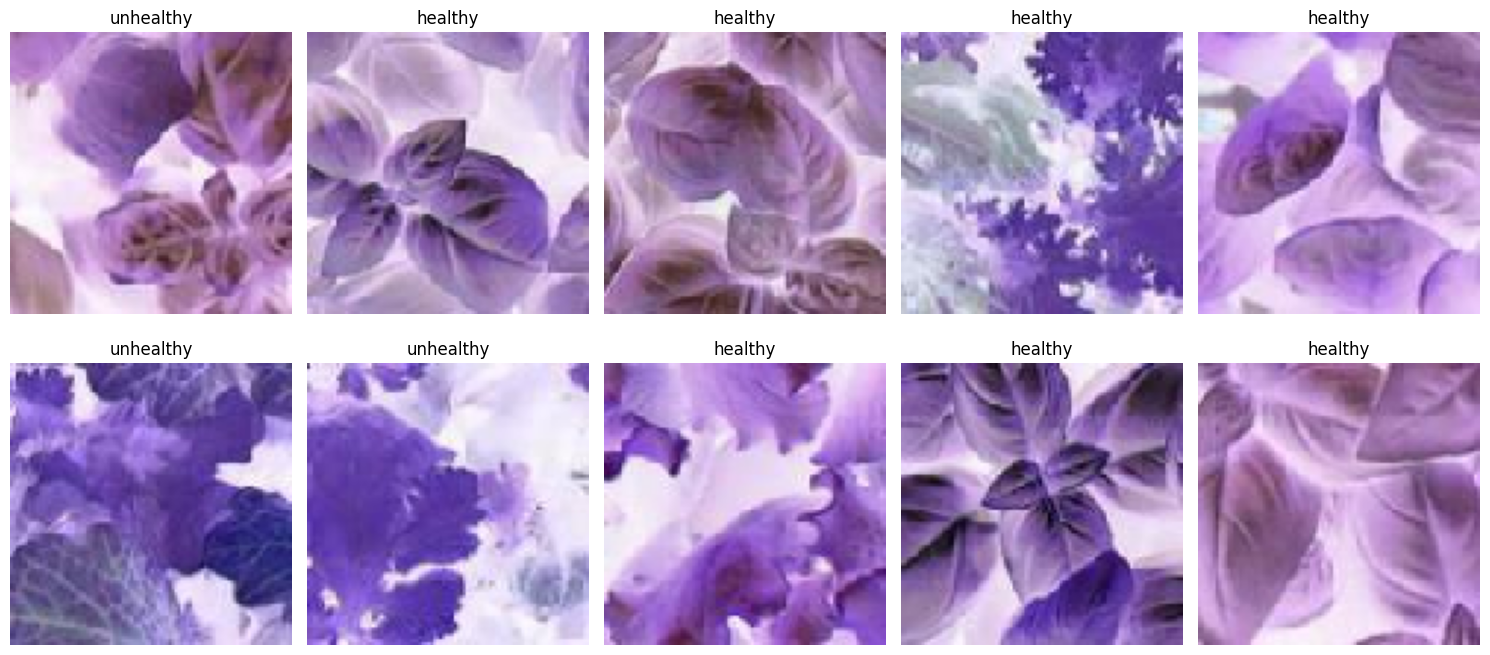

In [27]:
import matplotlib.pyplot as plt

# Select random 10 indices from the dataset
random_indices = np.random.choice(len(images), 10, replace=False)

# Get the random images and labels
random_images = images[random_indices]
random_labels = labels[random_indices]

# Normalize the images to [0, 1]
random_images = random_images.astype('float32') / 255

# Plot the random images with labels
plt.figure(figsize=(15, 7))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    inverted_image = 255 * np.ones_like(random_images[i]) - random_images[i]
    from PIL import Image, ImageChops

    # Opening the test image, and saving it's objec

    # Passing the image object to invert()
    numpy_array_uint8 = (random_images[i] * 255).astype(np.uint8)

    inv_img = ImageChops.invert(Image.fromarray(numpy_array_uint8))
    plt.imshow(inv_img)
    plt.title(random_labels[i])
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# mount it
from google.colab import drive
drive.mount('/content/drive')
# copy it there
!cp -r images.zip /content/drive/MyDrive

#Model

In [31]:
"""
for i, img in enumerate(images):
  numpy_array_uint8 = image.astype(np.uint8)

  inv_img = ImageChops.invert(Image.fromarray(numpy_array_uint8))
  images[i] = np.array(inv_img)
"""

In [18]:
BEST_MODEL_PATH = "/content/best_model_weights.h5"

In [25]:
from keras.layers.experimental.preprocessing import Rescaling
from keras import Input
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten


# Convert labels to binary format
labels_binary = np.where(labels == 'healthy', 0, 1)

# Split dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, labels_binary, test_size=0.2, stratify=labels_binary, random_state=8)

normalization_layer = Rescaling(1./255)

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(96, 96, 3))

# Add custom layers for binary classification
inputs = Input(shape=(96, 96, 3), name="input")
x = normalization_layer(inputs)
x = base_model(x)

x = Flatten()(x)
predictions = Dense(1, activation='sigmoid')(x)
model = Model(inputs=inputs, outputs=predictions)

# Compile the model
model.compile(optimizer=AdamW(), loss='binary_crossentropy', metrics=["accuracy"])

# Train the model with early stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True)
checkpoint = ModelCheckpoint(BEST_MODEL_PATH, save_best_only=True, save_weights_only=True, monitor='val_accuracy', mode='max', verbose=1)

model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 rescaling_6 (Rescaling)     (None, 96, 96, 3)         0         
                                                                 
 inception_v3 (Functional)   (None, 1, 1, 2048)        21802784  
                                                                 
 flatten_5 (Flatten)         (None, 2048)              0         
                                                                 
 dense_6 (Dense)             (None, 1)                 2049      
                                                                 
Total params: 21804833 (83.18 MB)
Trainable params: 21770401 (83.05 MB)
Non-trainable params: 34432 (134.50 KB)
_________________________________________________________________


#Training

In [26]:
model.fit(X_train, y_train, batch_size=128, epochs=30, validation_data=(X_val, y_val), callbacks=[checkpoint, early_stopping])

Epoch 1/30
32/32 [==============================] - ETA: 0s - loss: 0.6180 - accuracy: 0.6892
Epoch 1: val_accuracy improved from -inf to 0.38062, saving model to /content/best_model_weights.h5
32/32 [==============================] - 38s 251ms/step - loss: 0.6180 - accuracy: 0.6892 - val_loss: 208.3364 - val_accuracy: 0.3806
Epoch 2/30
32/32 [==============================] - ETA: 0s - loss: 0.4031 - accuracy: 0.8246
Epoch 2: val_accuracy improved from 0.38062 to 0.62138, saving model to /content/best_model_weights.h5
32/32 [==============================] - 6s 183ms/step - loss: 0.4031 - accuracy: 0.8246 - val_loss: 55.3967 - val_accuracy: 0.6214
Epoch 3/30
32/32 [==============================] - ETA: 0s - loss: 0.3137 - accuracy: 0.8796
Epoch 3: val_accuracy did not improve from 0.62138
32/32 [==============================] - 5s 170ms/step - loss: 0.3137 - accuracy: 0.8796 - val_loss: 99.3061 - val_accuracy: 0.6194
Epoch 4/30
32/32 [==============================] - ETA: 0s - loss

#Test

32/32 [==============================] - 2s 42ms/step


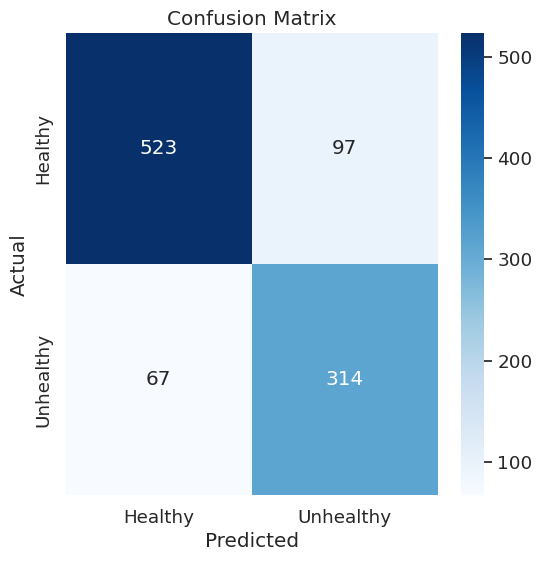

In [9]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import load_model

# Load the pre-trained model
model.load_weights(BEST_MODEL_PATH)

# Make predictions on the validation set
y_pred = model.predict(X_val)

y_pred_classes = (y_pred > 0.5).astype(int)
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred_classes)
class_names = ["Healthy", "Unhealthy"]

# Plot the confusion matrix using seaborn
plt.figure(figsize=(6, 6))
sns.set(font_scale=1.2)  # Adjust the font size for better visibility
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [10]:
from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred_classes))

              precision    recall  f1-score   support

           0       0.89      0.84      0.86       620
           1       0.76      0.82      0.79       381

    accuracy                           0.84      1001
   macro avg       0.83      0.83      0.83      1001
weighted avg       0.84      0.84      0.84      1001



#Convert to the required format

In [15]:
import tensorflow as tf

tf.keras.models.save_model(model, "saved_model")